## **COURSEWORK - Python and R programming language**
### TITLE: Diabetes database analysis - diabetes risk
#### AUTHOR: Krzysztof Pietruczuk
#### DATE: January 24, 2023

---------------

The work uses the diabetes.csv database from the https://www.kaggle.com/ website. This is an original dataset from The National Institute of Diabetes and Digestive and Kidney Diseases. The aim of the study is to determine the possibility of predicting whether a patient has diabetes or not, based on specific diagnostic parameters. The analysis was performed in Python using the following libraries: Pandas, NumPy, Matplotlib, scikit-learn.

-------

In [1]:
# loading the needed libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
data = pd.read_csv("diabetes.csv", sep=',')           # Loading data from the diabetes.csv file 

> #### **INITIAL ANALYSIS OF THE DATA SET**

In [3]:
data.head()                                           # Dataframe header and first 5 records

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
data.info()                                          # General information about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


----------------------------
We obtained the following information: The database consists of 9 columns and 768 records. Two columns (BMI and DiabetesPedigreeFunction) are float64, the rest are integer data. There are no missing values (NaN) in the database. The data takes up 54.1 KB of memory.
Column content description:

| column                   |   | description                    
|--------------------------|---|:------------------------------------------:
| Pregnancies              |   | number of pregnancies                
| Glucose                  |   | glucose level in the tolerance test (2h)            
| BloodPressure            |   | diastolic blood pressure value     
| SkinThickness            |   | triceps skinfold thickness              
| Insulin                  |   | insulin level in the insulin test (2h)           
| BMI                      |   | body mass index        
| DiabetesPedigreeFunction |   | indicator - percentage of diabetes
| Age                      |   | age                       
| Outcome                  |   | 1 - there is diabetes, 0 - absent

--------------
We will now check the correctness of the data contained in the individual columns. First, a general look at the statistics of the individual columns.

In [5]:
data.describe().applymap('{:,.2f}'.format)                      # Basic descriptive statistics

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24,0.35
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


We have 768 records. In the Pregnancies column, the value 17 may seem like an error, it will definitely be an outlier. The Glucose, BloodPressure, SkinThickness, Insulin and BMI columns definitely need repair, because their minimum value is 0. The maximum value of insulin will also be incorrect because the norm after 2 hours from the consumption of 75 g of glucose is <30 uIU / ml. The maximum value of the SkinThickness column is likely to be the outlier.

In [6]:
data['Outcome'].value_counts()                                  # Unique values appearing in the Outcome column and their amount, like this
                                                                # we can make sure that the only values in this column are 0 and 1

0    500
1    268
Name: Outcome, dtype: int64

From checking the unique values of the Outcomes column, we find out that there are 268 people with diagnosed diabetes and 500 healthy people in the database. The only values that appear in this column are 0 and 1 as expected.<br>
Before deciding what to do with abnormal values in the Glucose, BloodPressure, SkinThickness, Insulin, and BMI columns, we need to look at the frequency of the variable values.
We do this graphically using frequency histograms and checking the exact number of nulls along with their distribution for our goal variable, Outcome.

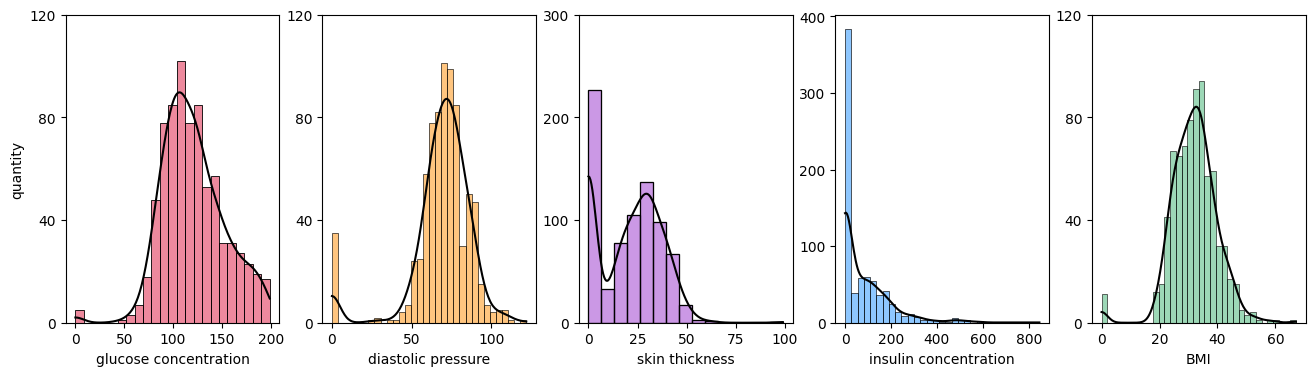

In [7]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(16,4))            # Histograms from the frequencies of individual column values with a marked density line

sns.histplot(data['Glucose'], kde=True, ax=ax1, color='#DC143C')              # Column Glucose
sns.histplot(data['BloodPressure'], kde=True, ax=ax2, color='#FF8C00')        # Column BloodPressure
sns.histplot(data['SkinThickness'], kde=True, ax=ax3, color='#9932CC')        # Column SkinThickness
sns.histplot(data['Insulin'], kde=True, ax=ax4, color='#1E90FF')              # Column Insulin
sns.histplot(data['BMI'], kde=True, ax=ax5, color='#3CB371')                  # Column BMI

ax1.lines[0].set_color('black')                                               # UDensity line color setting
ax2.lines[0].set_color('black')
ax3.lines[0].set_color('black')
ax4.lines[0].set_color('black')
ax5.lines[0].set_color('black')

ax1.set_ylabel('quantity')                                                       # Set x and y axis labels for individual graphs
ax1.set_xlabel('glucose concentration')
ax2.set_ylabel('')
ax2.set_xlabel('diastolic pressure')
ax3.set_ylabel('')
ax3.set_xlabel('skin thickness')
ax4.set_ylabel('')
ax4.set_xlabel('insulin concentration')
ax5.set_ylabel('')
ax5.set_xlabel('BMI')

ax1.set_yticks([0,40,80,120])                                                # Setting the y-axis scale for individual graphs
ax2.set_yticks([0,40,80,120])
ax3.set_yticks([0,100,200,300])
ax4.set_yticks([0,100,200,300,400])
ax5.set_yticks([0,40,80,120])


plt.show()                                                                   # Bulk display of histograms

In [8]:
print(data[data.Glucose == 0].shape[0])                                   # Printing the total number of 0 values in the Glucose column
print(data[data.Glucose == 0].groupby('Outcome') ['Age'].count())         # Checking how this value is distributed depending on the Outcome column

5
Outcome
0    3
1    2
Name: Age, dtype: int64


In [9]:
print(data[data.BloodPressure == 0].shape[0])                              # Printing the total number of 0 values in the BloodPressure column
print(data[data.BloodPressure == 0].groupby('Outcome') ['Age'].count())    # Checking how this value is distributed depending on the Outcome column

35
Outcome
0    19
1    16
Name: Age, dtype: int64


In [10]:
print(data[data.SkinThickness == 0].shape[0])                               # Printing the total number of 0 values in the SkinThickness column
print(data[data.SkinThickness == 0].groupby('Outcome') ['Age'].count())     # Checking how this value is distributed depending on the Outcome column

227
Outcome
0    139
1     88
Name: Age, dtype: int64


In [11]:
print(data[data.Insulin == 0].shape[0])                                     # Printing the total number of 0 values in the Insulin column
print(data[data.Insulin == 0].groupby('Outcome') ['Age'].count())           # Checking how this value is distributed depending on the Outcome column

374
Outcome
0    236
1    138
Name: Age, dtype: int64


In [12]:
print(data[data.BMI == 0].shape[0])                                         # Printing the total number of 0 values in the Age column
print(data[data.BMI == 0].groupby('Outcome') ['Age'].count())               # Checking how this value is distributed depending on the Outcome column

11
Outcome
0    9
1    2
Name: Age, dtype: int64


<u>Summary of information obtained:</u><br>
**Glucose** has 5 counts of 0 values that are evenly distributed between people diagnosed with diabetes and healthy people.<br>
**BloodPressure** has 35 counts of 0 values, which are distributed fairly evenly between people diagnosed with diabetes and healthy people.<br>
**SkinThickineese** has 227 counts of 0, mostly healthy people.<br>
**Insulin** has 374 counts of 0 value, mostly healthy people in this group.<br>
**BMI** has 11 counts of 0 values, healthy people predominate in this group.<br>
<u>Conclusions:</u><br>
In the columns Glucose, BloodPressure and BMI, in place of the zero value, we will insert the value of the location measure corresponding to the given column, which is the average. This should not interfere with data analysis in any way. SkinThickness and Insulin columns are more problematic. The number of zeros in these columns is very large, potentially removing them would result in the loss of a large amount of data, but if we wanted to use some measure of location, we could falsify the data - especially when it comes to insulin concentration values. For now, we'll cover the Glucose, BloodPressure, and BMI columns.

In [13]:
# Substitute for the value 0, the average value for the given column

data['Glucose'].replace(0, data['Glucose'].mean(), inplace=True)
data['BloodPressure'].replace(0, data['BloodPressure'].mean(), inplace=True)
data['BMI'].replace(0, data['BMI'].mean(), inplace=True)


We now identify outliers in the Skin Thickness and Insulin columns. <br>
Graphical presentation of outliers.

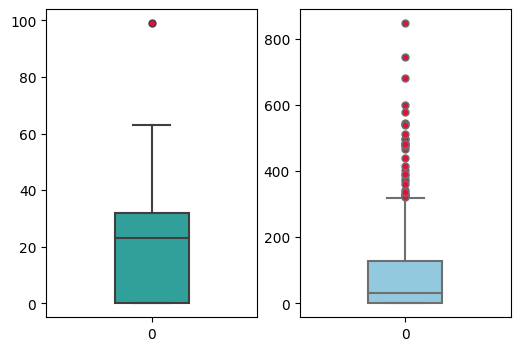

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,4))                           # WBoxplots and outliers
color_circle = dict(markerfacecolor='#DC143C', marker='o')
sns.boxplot(data['SkinThickness'], flierprops=color_circle, color='#20B2AA', ax=ax1, width=0.35)  
sns.boxplot(data['Insulin'], flierprops=color_circle, color='#87CEEB', ax=ax2, width=0.35)

plt.show()                                                                   # Bulk display of boxplots

Calculation of the outlier values of the SkinThickness and Insulin columns.

In [15]:
data[['SkinThickness','Insulin']].quantile(np.arange(0.0, 1.1, 0.1)).applymap('{:,.2f}'.format).T       # Percentile data

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
SkinThickness,0.00,0.00,0.00,8.20,18.00,23.00,27.00,31.00,35.00,40.00,99.00
Insulin,0.00,0.00,0.00,0.00,0.00,30.50,72.20,106.00,150.00,210.00,846.00


In [16]:
upper_limit = data.SkinThickness.quantile(.99)               # Determining outliers using percentiles. As lower
lower_limit = data.SkinThickness.quantile(.01)               # the lower bound was designated the 1st percentile as the upper 99th percentile.

print('outliers', '---<', "{:.2f}".format(lower_limit), '---data set---', "{:.2f}".format(upper_limit), '>---', 'outliers')

outliers ---< 0.00 ---data set--- 51.33 >--- outliers


In [17]:
upper_limit = data.Insulin.quantile(.99)                     # Determining outliers using percentiles. As lower
lower_limit = data.Insulin.quantile(.01)                     # the lower bound was designated the 1st percentile as the upper 99th percentile.

print('outliers', '---<', "{:.2f}".format(lower_limit), '---data set---', "{:.2f}".format(upper_limit), '>---', 'outliers')

outliers ---< 0.00 ---data set--- 519.90 >--- outliers


Remove outliers.

In [18]:
data.drop(data.loc[data['SkinThickness'] > 51.33].index, inplace=True)
data.drop(data.loc[data['Insulin'] > 519.90].index, inplace=True)

Look at some data parameters to decide on invalid values.

In [19]:
print('number of all records in the table after removing outliers: ', len(data))
print('Breakdown of all records by healthy (0) and diabetic (1): ')
print(data.groupby('Outcome') ['Age'].count())
print('---------------------------')
print('Records that have a value of 0 in both the SkinThickness and Insulin columns: ', len(data[(data.SkinThickness == 0)&(data.Insulin == 0)]))
print('Breakdown of these records by healthy (0) and diabetic (1):') 
print(data[(data.SkinThickness == 0)&(data.Insulin == 0)].groupby('Outcome') ['Age'].count())


number of all records in the table after removing outliers:  752
Breakdown of all records by healthy (0) and diabetic (1): 
Outcome
0    492
1    260
Name: Age, dtype: int64
---------------------------
Records that have a value of 0 in both the SkinThickness and Insulin columns:  227
Breakdown of these records by healthy (0) and diabetic (1):
Outcome
0    139
1     88
Name: Age, dtype: int64


<u>Conclusions:</u><br>
We have 752 records, of which the healthy group is 492 records, the rest are people with diabetes. The records with a zero value in both the SkinThickness column and the Insulin column amount to a total of 227, of which 139 are healthy and 88 are sick. These records account for 30.2% of the entire base. At the same time, this 30.2% includes all zero records in the SkinThickness column.
We can proceed in two ways:<br>
1) we put in place of zero values, e.g., the average of a given set - the disadvantage is that there are a lot of zero values, so it will falsify the result a bit, and in the Insulin column, the average will be inflated due to the still high maximum value, which is still a bit unrealistic.
2) we delete records that have a zero value in the SkinThickness and Insulin columns at the same time, and we change the remaining zero values in Insulin to the average - the disadvantage is that we lose a lot of information (the whole is: 30.2%, healthy people are: 28.25%, patients: 33.84%) and the data in the Insulin column will be falsified.
3) remove the Insulin column from the analysis, and insert average values in the SkiThikness column.<br>

<u>Decision made:</u><br>
I decide on the third method.<br>
<u>Justification:</u><br>
According to the guidelines, insulin should be below 30 mU/ml two hours after the glucose challenge. Determination of insulin concentration in the blood serum is performed to confirm insulin resistance and detect the cause of hypoglycaemia. Low fasting insulin may indicate genetically determined type 1 diabetes. High fasting insulin, on the other hand, suggests insulin resistance, which is the first stage of the development of type 2 diabetes. In other words, this parameter is useful in further diagnosis. It is not marked in the initial diagnosis. Therefore, this column will be deleted. In the SkinThickness column, the average values will be inserted in the place of zeros.


In [20]:
data.drop('Insulin', axis=1, inplace=True)                                         # Remove the Insulin column from the dataframe

In [21]:
data['SkinThickness'].replace(0, data['SkinThickness'].mean(), inplace=True)       # Substitute for 0, the mean value for the SkinThickness column

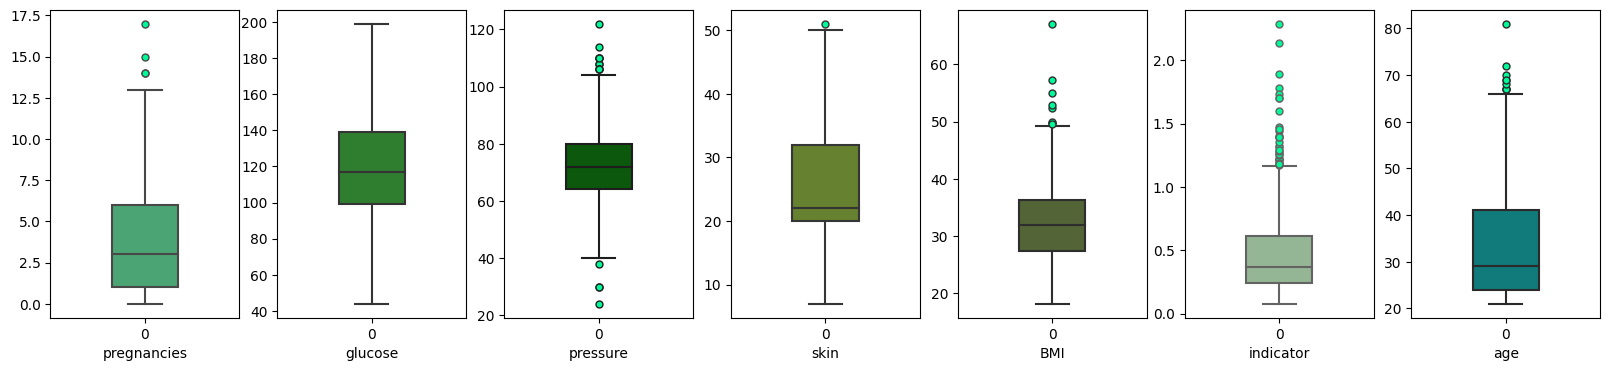

In [22]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1,7, figsize=(20,4))       # Boxplots and outliers
red_circle = dict(markerfacecolor='#00FA9A', marker='o')

sns.boxplot(data['Pregnancies'], flierprops=red_circle, color='#3CB371', ax=ax1, width=0.35)
sns.boxplot(data['Glucose'], flierprops=red_circle, color='#228B22', ax=ax2, width=0.35) 
sns.boxplot(data['BloodPressure'], flierprops=red_circle, color='#006400', ax=ax3, width=0.35) 
sns.boxplot(data['SkinThickness'], flierprops=red_circle, color='#6B8E23', ax=ax4, width=0.35) 
sns.boxplot(data['BMI'], flierprops=red_circle, color='#556B2F', ax=ax5, width=0.35) 
sns.boxplot(data['DiabetesPedigreeFunction'], flierprops=red_circle, color='#8FBC8F', ax=ax6, width=0.35) 
sns.boxplot(data['Age'], flierprops=red_circle, color='#008B8B', ax=ax7, width=0.35) 

ax1.set_xlabel('pregnancies')
ax2.set_xlabel('glucose')
ax3.set_xlabel('pressure')
ax4.set_xlabel('skin')
ax5.set_xlabel('BMI')
ax6.set_xlabel('indicator')
ax7.set_xlabel('age')

plt.show()

Accurate determination of outliers.

In [23]:
upper_limit = data.Pregnancies.quantile(.99)                        # Determining outliers using percentiles. As lower
lower_limit = data.Pregnancies.quantile(.01)                        # the lower bound was designated the 1st percentile as the upper 99th percentile.

print('outliers', '---<', "{:.2f}".format(lower_limit), '---data set---', "{:.2f}".format(upper_limit), '>---', 'outliers')

outliers ---< 0.00 ---data set--- 13.00 >--- outliers


In [24]:
upper_limit = data.BloodPressure.quantile(.99)                      # Determining outliers using percentiles. As lower
lower_limit = data.BloodPressure.quantile(.01)                      # the lower bound was designated the 1st percentile as the upper 99th percentile.

print('outliers', '---<', "{:.2f}".format(lower_limit), '---data set---', "{:.2f}".format(upper_limit), '>---', 'outliers')

outliers ---< 44.00 ---data set--- 106.00 >--- outliers


In [25]:
upper_limit = data.SkinThickness.quantile(.99)                      # Determining outliers using percentiles. As lower
lower_limit = data.SkinThickness.quantile(.01)                      # the lower bound was designated the 1st percentile as the upper 99th percentile.

print('outliers', '---<', "{:.2f}".format(lower_limit), '---data set---', "{:.2f}".format(upper_limit), '>---', 'outliers')

outliers ---< 10.00 ---data set--- 48.00 >--- outliers


In [26]:
upper_limit = data.BMI.quantile(.99)                                # Determining outliers using percentiles. As lower
lower_limit = data.BMI.quantile(.01)                                # the lower bound was designated the 1st percentile as the upper 99th percentile.

print('outliers', '---<', "{:.2f}".format(lower_limit), '---data set---', "{:.2f}".format(upper_limit), '>---', 'outliers')

outliers ---< 19.50 ---data set--- 49.45 >--- outliers


In [27]:
upper_limit = data.DiabetesPedigreeFunction.quantile(.99)           # Determining outliers using percentiles. As lower
lower_limit = data.DiabetesPedigreeFunction.quantile(.01)           # the lower bound was designated the 1st percentile as the upper 99th percentile.

print('outliers', '---<', "{:.2f}".format(lower_limit), '---data set---', "{:.2f}".format(upper_limit), '>---', 'outliers')

outliers ---< 0.09 ---data set--- 1.54 >--- outliers


In [28]:
data.drop(data.loc[data['Pregnancies'] > 13].index, inplace=True)

data.drop(data.loc[data['BloodPressure'] < 44].index, inplace=True)
data.drop(data.loc[data['BloodPressure'] > 106].index, inplace=True)

data.drop(data.loc[data['SkinThickness'] < 10].index, inplace=True)
data.drop(data.loc[data['SkinThickness'] > 48].index, inplace=True)

data.drop(data.loc[data['BMI'] > 49.45].index, inplace=True)

data.drop(data.loc[data['DiabetesPedigreeFunction'] < 0.09].index, inplace=True)
data.drop(data.loc[data['DiabetesPedigreeFunction'] > 1.54].index, inplace=True)

In [29]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
count,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000
mean,3.852900,120.829523,72.053163,25.753641,31.943601,0.452489,33.182461,0.338048
std,3.258178,29.939209,11.094167,8.572460,6.248890,0.283575,11.781621,0.473380
min,0.000000,44.000000,44.000000,10.000000,18.200000,0.092000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,19.944149,27.400000,0.244500,24.000000,0.000000
50%,3.000000,117.000000,72.000000,22.000000,31.992578,0.365000,29.000000,0.000000
75%,6.000000,139.000000,80.000000,32.000000,35.800000,0.605000,41.000000,1.000000
max,13.000000,199.000000,106.000000,48.000000,49.300000,1.476000,81.000000,1.000000


Checking the correlation between variables.

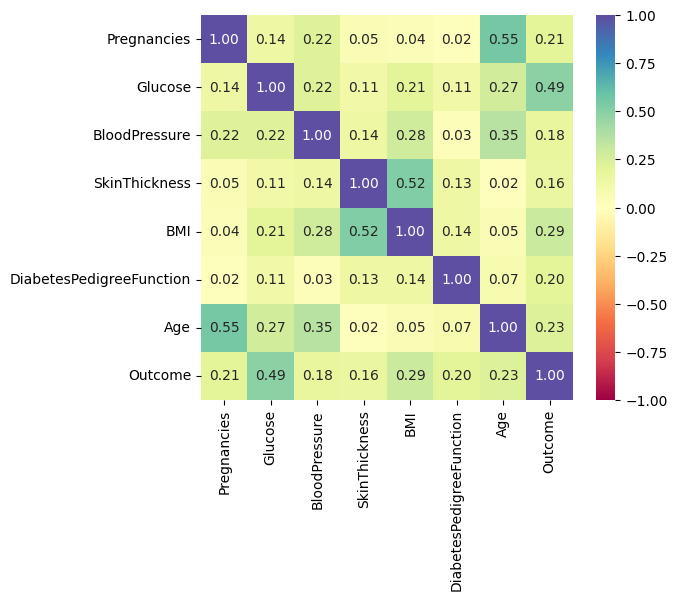

In [30]:
fig, (axes) = plt.subplots(1,1, figsize=(6,5))
sns.heatmap(data.corr(), cmap='Spectral', annot=True, fmt='.2f', center=0, vmin=-1, vmax=1)
plt.show()

> #### **DATA MODELING**

<u>Preparation of datasets for modeling.</u> <br>
We divide the dataset into an objective variable y (the explanatory variable) and a set of predictors X (the explanatory variables). We also take 70% of the values in the table as the training dataset and the remaining 30% as the test dataset. The objective variable is the Outcome column and the predictors are the Pregnancies, Glucose, BloodPressure, SkinThickness, BMI, DiabetesPedigreeFunction, Age columns.

In [31]:
y = data.Outcome                                                          # Defining the objective variable y
X = data.drop('Outcome', axis=1)                                          # Defining explanatory variables
sc = StandardScaler()
X = sc.fit_transform(X)

<u>Model selection.</u><br>
We check seven classifiers, they will be K-Nearest Neighbors, Support Vector Classifier, Logistic Regression, Gaussian Naive Bayes, Random Forest and Gradient Boost to find out which one is the best. We calculate the classification accuracy of a given set of classification models to determine which model works best with the diabetes dataset.

In [32]:
models = []                                                                                                  # Creating a list of models to choose from
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC()))
models.append(('LR', LR()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=30, stratify=y)      # Divided into test and training parts

In [34]:
names = []
scores = []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    names.append(name)
    
tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)

  Name     Score
0  KNN  0.690141
1  SVC  0.765258
2   LR  0.774648
3   DT  0.732394
4  GNB  0.755869
5   RF  0.765258
6   GB  0.765258


In [35]:
names = []                                                                                                   # Cross validation
scores = []

for name, model in models:    
    kfold = KFold(n_splits=20, random_state=None, shuffle=False) 
    score = cross_val_score(model, X, y, cv=kfold, scoring='accuracy').mean()    
    names.append(name)
    scores.append(score)
    
kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(kf_cross_val)

  Name     Score
0  KNN  0.734286
1  SVC  0.751230
2   LR  0.766786
3   DT  0.707500
4  GNB  0.756944
5   RF  0.755595
6   GB  0.741349


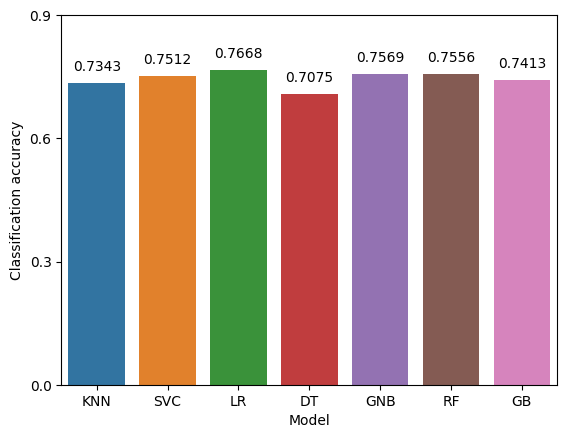

In [36]:
axis = sns.barplot(x = 'Name', y = 'Score', data = kf_cross_val)                                            # Compare the results using a barplot plot
axis.set(xlabel='Model', ylabel='Classification accuracy')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.03, '{:1.4f}'.format(height), ha="center") 
    axis.set_yticks([0,0.3,0.6,0.9])
plt.show()

<u>Result obtained.</u><br>
The best model turned out to be logistic regression with the result of classification accuracy equal to: 0.7668.

In [37]:
params = {'C': [0.001, 0.01, 0.1, 1.0],'penalty': ['l1', 'l2']}                    # Defining parameters

log_reg = LR(random_state=42, class_weight='balanced',solver='liblinear')          # Logistic regression model initialization

log_reg_cv = GridSearchCV(log_reg, param_grid=params, cv=5, scoring='accuracy')    # Initialize and use the best parameters for the model

log_reg_cv.fit(X_train, y_train)                                                   # Model training

y_pred = log_reg_cv.predict(X_test)                                                # Prediction

print(f'Prediction: {y_pred[:10]}')                                                # Results
print('Best score: ', log_reg_cv.best_score_)
print('Best params: ', log_reg_cv.best_params_)
print('Score: ', log_reg_cv.score(X_test, y_test))

Prediction: [1 0 1 1 1 1 0 1 1 0]
Best score:  0.736837765409194
Best params:  {'C': 1.0, 'penalty': 'l2'}
Score:  0.755868544600939


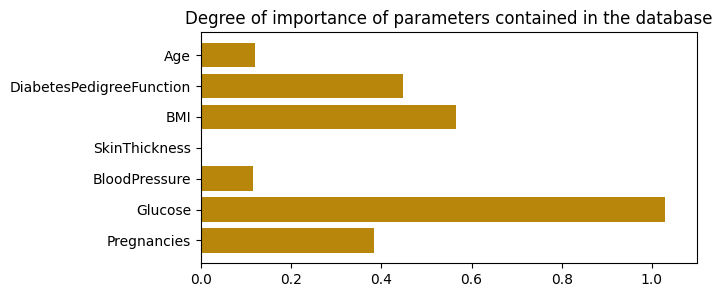

In [38]:
feature_imp = log_reg_cv.best_estimator_.coef_[0]                                   # Estimating the importance of predictor variables

# raphical representation of estimated variable importances
kolumny = ['Pregnancies','Glucose','BloodPressure','SkinThickness','BMI','DiabetesPedigreeFunction','Age']
f = plt.figure()                                                                    
f.set_figheight(3)
plt.barh([x for x in range(len(feature_imp))], feature_imp, height = 0.8, color='#B8860B')
plt.title('Degree of importance of parameters contained in the database')
labels = list(kolumny) 
plt.xlim(0,1.1)
plt.yticks(range(len(labels)), labels)
plt.show()


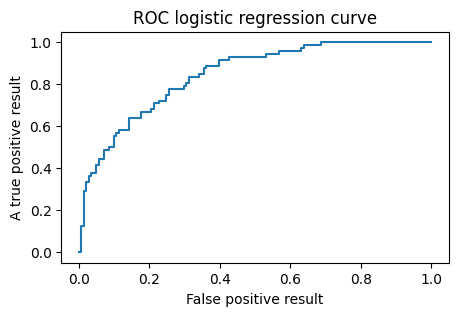

In [39]:
y_pred_prob = log_reg_cv.predict_proba(X_test)[:,1]                                 # Evaluation of the model using the curve of the operating characteristic of the receiver
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
 
fig, (axes) = plt.subplots(1,1, figsize=(5,3))
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False positive result')
plt.ylabel('A true positive result')
plt.title('ROC logistic regression curve')
plt.show()

In [40]:
y_pred_prob = log_reg_cv.predict_proba(X_test)[:,1]                                # ROC value
roc_auc_score(y_test, y_pred_prob)

0.8434791174152877

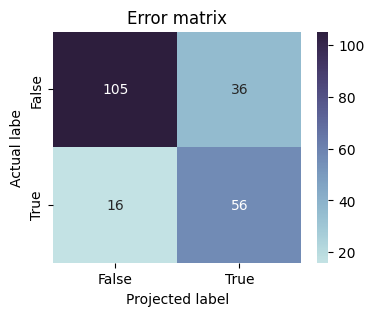

In [41]:
cf_matrix = confusion_matrix(y_test, y_pred)                                       # Creating a confusion matrix

fig, (axes) = plt.subplots(1,1, figsize=(4,3))                                     # Matrix presented graphically
color = sns.color_palette("ch:s=.35,rot=-.35", as_cmap=True)
ax = sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap=color)
ax.set_title('Error matrix');
ax.set_xlabel('Projected label')
ax.set_ylabel('Actual labe');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

<u>Conclusions from the analysis</u> <br>
For the prepared data and after applying the best model, we obtained that the most important parameter in predicting the incidence of diabetes is the level of glucose in the examined person. Since the triceps skinfold thickness parameter turned out to be the least useful, the analysis could also be carried out after its removal and then the results could be compared.
A large advantage of the glucose concentration parameter over other explanatory variables was to be expected.